In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
import datetime
import ssl
from matplotlib.ticker import PercentFormatter
import plotly.graph_objects as go

In [2]:
def convertDate(date):
    dates = date.split("-")
    convert = datetime.date(int(dates[0]), int(dates[1]), int(dates[2]))
    return convert

In [3]:
def connectivity(edgeSentiments):
    posPos = 0
    negNeg = 0
    posNeg = 0

    for pair in edgeSentiments:
        if np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == 1:
            posPos += 1
        elif np.sign(pair[0]) == np.sign(pair[1]) and np.sign(pair[0]) == -1:
            negNeg += 1
        elif np.sign(pair[0]) != np.sign(pair[1]) and pair[0] != 0 and pair[1] != 0:
            posNeg += 1
    return posPos,negNeg, posNeg

def rawConnectivity(edgeSentiments):
    connections = []
    for pair in edgeSentiments:
        if np.sign(pair[0]) != 0 and np.sign(pair[1]) != 0:
            connections.append([np.sign(pair[0]),np.sign(pair[1])])
    return connections
    
    
    

# Look at data

In [4]:
#Load Data
data = pd.read_csv("GawaherSentiment.csv", index_col=0)
threads = data["ThreadID"].unique()

In [5]:
#look at individual threads
thread = data[data["ThreadID"]== threads[0]]
thread.head()

,MessageID,ThreadID,ThreadName,MemberID,MemberName,Message,P_Year,P_Month,P_Day,P_Date,ThreadFirstMessageID,NLTK,SentiStrength,AllenNLP
0,1000,240,Music in Islam,Moustafa,Moustafa,"<quote>Quote Assalaamualaikum, Regardless of w...",2004,10,25,2004-10-25 18:22:00.000,806,0.9246,0.458831,-0.072225
77,1003,240,Music in Islam,Paki Brother,Paki Brother,"Like I was saying brother, That is what is en...",2004,10,25,2004-10-25 18:25:00.000,806,0.3612,0.250000,-0.973983
33898,1509,240,Music in Islam,Guest_Sulemaan_*,Guest_Sulemaan_*,"My Deaer Moustafa, You are missing a major poi...",2004,10,26,2004-10-26 07:17:00.000,806,0.4215,-0.612372,-0.039299
33998,1516,240,Music in Islam,Guest_Sulemaan_*,Guest_Sulemaan_*,"<quote>Moustafa, on Oct 25 2004, 09:22 PM, sai...",2004,10,26,2004-10-26 07:24:00.000,806,0.9287,0.458831,-0.066808
34023,1517,240,Music in Islam,Crystal Eyes,Crystal Eyes,applauds for sulemaan!! honestly why there is ...,2004,10,26,2004-10-26 07:30:00.000,806,0.8316,0.790569,0.184105


# Get Metrics From All Threads

In [8]:
#Load Data
data = pd.read_csv("GawaherSentiment.csv", index_col=0)
threads = data["ThreadID"].unique()

meanSentiment = []
posterSentiment = []
posterCentrality = []
numPosterPosts = []
numMembers = []
numPosts = []
allConnection = []
uniqueConnection = []
rawConnections = []
rawUniqueConnections = []

for num in range(0,len(threads)):
    thread = data[data["ThreadID"]== threads[num]]
    thread = thread.reset_index(drop = True)

    #get all messages
    messages = thread["Message"].copy()
    
    #sort by datetime
    for i in range(0,len(thread)):
        thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
    thread = thread.sort_values(by = ["P_Date",'MessageID'])
    
    #Encode non-numerical members
    index = -1
    members = thread["MemberID"].unique()
    for i in range(0,len(members)):
        try:
            int(members[i])
        except:
            thread["MemberID"][thread["MemberID"] == members[i]] = str(index)
            members[i] = str(index)
            index -= 1
    
    memberSentiments = []
    memberCommnets = []
    for i in members:
        memberCommnets.append(len(thread[thread["MemberID"] == i]))
        memberSentiments.append(np.mean(thread[thread["MemberID"] == i]["AllenNLP"]))
                                
              
    #Make graph
    #Make dictionary of nodes (members) with corresponding mean sentiment of that member
    nodes = np.array(members,dtype = int)
    nodeDict = dict(zip(nodes,np.around(memberSentiments,4)))
    
    edges = []
    for i in range(0,len(thread)-1):
        if thread["MemberID"].iloc[i] != thread["MemberID"].iloc[i +1]:
            edge = (tuple([int(thread["MemberID"].iloc[i]),int(thread["MemberID"].iloc[i+1])]))
            edges.append(edge)
    
    sortEdges = [np.sort(x) for x in edges]
    edgeKeys = np.unique(sortEdges,axis=0)
    edgeValues = []

    for i in range(0,len(edgeKeys)):
        count = 0
        for j in range(0,len(sortEdges)):
            count += np.array_equal(sortEdges[j],edgeKeys[i])
        edgeValues.append(count)

    edgeKeys=[tuple(edgeKeys.tolist()[x]) for x in range(0,len(edgeKeys))]
    edgeDict = dict(zip(edgeKeys,edgeValues))
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    #Get central tendency
    infoCentrality = nx.information_centrality(G)
    
    try:
        #Get all interacts between members also unique interactions between members (remove multiple replies)
        flatEdges = np.concatenate(edges)
        flatSentiments = np.array([nodeDict[x] for x in flatEdges])
        edgeSentiments = np.sort(flatSentiments.reshape(-1,2))
        uniqueSentiments = np.unique(np.sort(edgeSentiments),axis = 0)

        #Store metrics
        allConnection.append(list(connectivity(edgeSentiments))) 
        uniqueConnection.append(list(connectivity(uniqueSentiments)))
        
        rawConnections.append(rawConnectivity(edgeSentiments))
        rawUniqueConnections.append(rawConnectivity(uniqueSentiments))
        
        meanSentiment.append(np.mean(thread["AllenNLP"]))
        numPosts.append(len(messages))
        posterSentiment.append(memberSentiments[0])  
        posterCentrality.append(infoCentrality)
        numPosterPosts.append(len(thread[thread["MemberID"] == members[0]]))
        numMembers.append(len(members))
    except:
        pass

/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_49831/59483976.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["P_Date"][i] = convertDate(thread["P_Date"][i][:10])
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_49831/59483976.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread["MemberID"][thread["MemberID"] == members[i]] = str(index)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/algorithms/centrality/current_flow_closeness.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  betweenness[v] = 1.0 / (betweenness[v])


# Statistics

In [9]:
statistics = pd.DataFrame(np.array([posterSentiment, posterCentrality,numPosterPosts, meanSentiment, numPosts, numMembers]).T,
                          columns = ["posterSentiment", "posterCentrality", "numPosterPosts", "meanSentiment", "numPosts", "numMembers"])



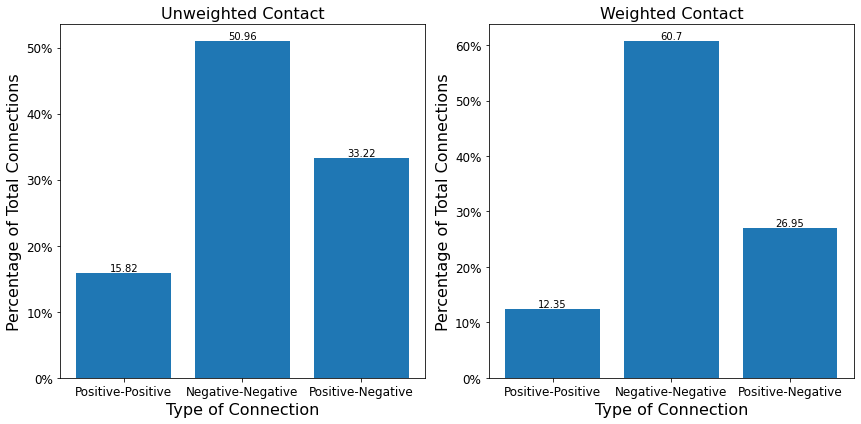

In [10]:
font = 16
tick = 12

plt.figure(figsize = (12,6))

plt.subplot(1,2,2)
plot1 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],
        (np.sum(allConnection, axis = 0)/np.sum(np.sum(allConnection, axis = 0))))
plt.title("Weighted Contact", fontsize = font)
plt.ylabel("Percentage of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot1,np.around(np.sum(allConnection, axis = 0)*100/np.sum(np.sum(allConnection, axis = 0)),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)

plt.subplot(1,2,1)
plot2 = plt.bar(["Positive-Positive","Negative-Negative","Positive-Negative"],
       (np.sum(uniqueConnection, axis = 0 )/np.sum(np.sum(uniqueConnection, axis = 0 ))))
plt.title("Unweighted Contact", fontsize = font)
plt.ylabel("Percentage of Total Connections", fontsize = font)
plt.xlabel("Type of Connection", fontsize = font)
plt.bar_label(plot2,np.around(np.sum(uniqueConnection, axis = 0)*100/np.sum(np.sum(uniqueConnection, axis = 0)),2))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.tight_layout()
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);

plt.savefig("intraThread.png")

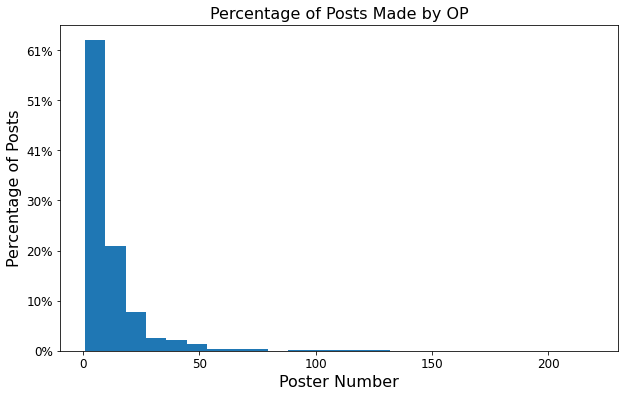

In [24]:
plt.figure(figsize = (10,6))
plt.hist(statistics["numPosterPosts"], bins = 25)#/statistics["numPosts"], bins = 25)
plt.title("Percentage of Posts Made by OP",fontsize = font)
plt.ylabel("Percentage of Posts",fontsize = font)
plt.xlabel("Poster Number",fontsize = font)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(statistics)));

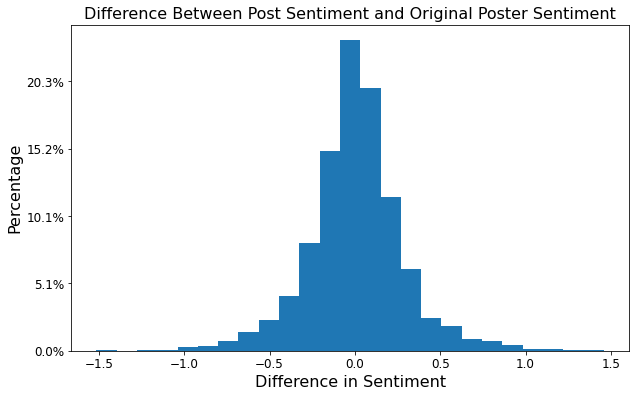

In [12]:
diff = statistics["posterSentiment"]-statistics["meanSentiment"]

plt.figure(figsize = (10,6))
plt.hist(diff, bins = 25)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(diff)))
plt.title("Difference Between Post Sentiment and Original Poster Sentiment", fontsize = font)
plt.xlabel("Difference in Sentiment", fontsize = font)
plt.ylabel("Percentage", fontsize = font);
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);
plt.savefig("diffSentiment.png")

In [13]:
np.mean(diff)

0.003108540921460182

In [14]:
np.std(diff)

0.28314335047828526

# Centrality 

In [15]:
centers = []

for i in range(0,len(posterCentrality)):
    centers.append(max(posterCentrality[i], key=posterCentrality[i].get)) 
centers = -1*np.array(centers)

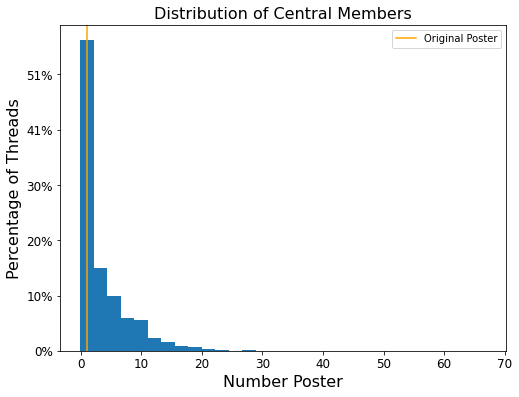

In [16]:
plt.figure(figsize = (8,6))
y = plt.hist(np.array(centers),bins = 30,  align='left')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax = len(centers)))
plt.xlabel("Number Poster", fontsize = font)
plt.ylabel("Percentage of Threads", fontsize = font)
plt.title("Distribution of Central Members", fontsize = font)
plt.axvline(x=1, c = "orange", label = "Original Poster")
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick);
plt.legend()
plt.savefig("intraCentrality.png");